In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Fetch historical daily data for Bitcoin
btc_real_price = yf.download('BTC-USD', start='2014-01-01', end='2024-01-31', progress=False)

# Define moving averages and stop-loss threshold
short_window = 10
long_window = 100
stop_loss_threshold = 0.8  # Example: stop loss at 20% below the buy price

In [ ]:
def trading_strategy(btc, plot_result=False, Rf=0.0):
    # Calculate moving averages
    btc['short_mavg'] = btc['Close'].rolling(window=short_window, min_periods=1).mean()
    btc['long_mavg'] = btc['Close'].rolling(window=long_window, min_periods=1).mean()

    # Define the trading signals
    btc['signal'] = 0.0
    btc['signal'] = np.where(btc['short_mavg'] > btc['long_mavg'], 1.0, 0.0)

    # Generate trading orders
    btc['positions'] = btc['signal'].diff()

    # Set the initial capital
    initial_capital = float(10000.0)

    # Create a DataFrame to hold the portfolio information
    portfolio = pd.DataFrame(index=btc.index)
    portfolio['holdings'] = 0.0
    portfolio['cash'] = initial_capital
    portfolio['total'] = initial_capital
    portfolio['stop_loss_price'] = np.nan

    # Trailing stop loss and portfolio value update
    for i in range(1, len(portfolio)):
        # Carry forward the number of holdings and cash
        portfolio.at[portfolio.index[i], 'holdings'] = portfolio.at[portfolio.index[i-1], 'holdings']
        portfolio.at[portfolio.index[i], 'cash'] = portfolio.at[portfolio.index[i-1], 'cash']

        # Update the stop loss price if there is a position
        if portfolio.at[portfolio.index[i-1], 'holdings'] > 0:
            portfolio.at[portfolio.index[i], 'stop_loss_price'] = max(
                portfolio.at[portfolio.index[i-1], 'stop_loss_price'],
                btc['Close'].iloc[i] * stop_loss_threshold
            )

        # Check for stop loss trigger
        if portfolio.at[portfolio.index[i], 'holdings'] > 0 and btc['Close'].iloc[i] < portfolio.at[portfolio.index[i], 'stop_loss_price']:
            portfolio.at[portfolio.index[i], 'cash'] += portfolio.at[portfolio.index[i], 'holdings'] * btc['Close'].iloc[i]
            portfolio.at[portfolio.index[i], 'holdings'] = 0
            portfolio.at[portfolio.index[i], 'stop_loss_price'] = np.nan

        # Check for buy signal
        elif btc['positions'].iloc[i] == 1:
            portfolio.at[portfolio.index[i], 'holdings'] = portfolio.at[portfolio.index[i], 'cash'] / btc['Close'].iloc[i]
            portfolio.at[portfolio.index[i], 'cash'] = 0
            portfolio.at[portfolio.index[i], 'stop_loss_price'] = btc['Close'].iloc[i] * stop_loss_threshold

        # Check for sell signal
        elif btc['positions'].iloc[i] == -1 and portfolio.at[portfolio.index[i], 'holdings'] > 0:
            portfolio.at[portfolio.index[i], 'cash'] += portfolio.at[portfolio.index[i], 'holdings'] * btc['Close'].iloc[i]
            portfolio.at[portfolio.index[i], 'holdings'] = 0
            portfolio.at[portfolio.index[i], 'stop_loss_price'] = np.nan

        # Update total portfolio value
        portfolio.at[portfolio.index[i], 'total'] = portfolio.at[portfolio.index[i], 'cash'] + portfolio.at[portfolio.index[i], 'holdings'] * btc['Close'].iloc[i]


    # Calculate returns
    portfolio['returns'] = portfolio['total'].pct_change()

    # Calculate total and annualized return
    total_return_percentage = ((portfolio['total'].iloc[-1] - initial_capital) / initial_capital) * 100
    days_in_backtest = (portfolio.index[-1] - portfolio.index[0]).days
    annualized_return = ((portfolio['total'].iloc[-1] / initial_capital) ** (365.0 / days_in_backtest)) - 1

    # Calculate Buy & Hold return
    buy_hold_return = ((btc['Close'].iloc[-1] - btc['Close'].iloc[0]) / btc['Close'].iloc[0]) * 100

    # Calculate the number of round-trip trades
    round_trips = btc['positions'].abs().sum() / 2

    # Calculate maximum drawdown
    peak = portfolio['total'].cummax()
    drawdown = (portfolio['total'] - peak) / peak
    max_drawdown = drawdown.min()

    # Calculate winning trade percentage
    # Initialize a list to keep track of each round-trip trade's profit or loss
    trade_results = []

    # Track the entry (buy) and exit (sell) prices for each trade
    entry_price = 0.0
    exit_price = 0.0

    # Loop through the DataFrame to evaluate each trade
    for i in range(1, len(btc)):
        # Check for a buy signal
        if btc['positions'].iloc[i] == 1:
            entry_price = btc['Close'].iloc[i]

        # Check for a sell signal
        elif btc['positions'].iloc[i] == -1 and entry_price != 0:
            exit_price = btc['Close'].iloc[i]
            # Calculate the result of the trade (profit if positive, loss if negative)
            trade_results.append(exit_price - entry_price)
            # Reset entry price for the next trade
            entry_price = 0

    # Calculate the percentage of winning trades
    winning_trades = len([result for result in trade_results if result > 0])
    winning_trades_percentage = (winning_trades / len(trade_results)) * 100 if trade_results else 0

    # Set the annual risk-free rate
    annual_risk_free_rate = Rf

    # Calculate daily risk-free rate assuming 252 trading days in a year
    daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1

    # Calculate Sharpe Ratio for the strategy
    strategy_returns = portfolio['returns'].dropna()
    excess_daily_returns = strategy_returns - daily_risk_free_rate
    strategy_sharpe_ratio = excess_daily_returns.mean() / excess_daily_returns.std() * np.sqrt(252)

    # Calculate Buy & Hold Strategy Returns
    buy_hold_returns = btc['Close'].pct_change().dropna()
    excess_bh_daily_returns = buy_hold_returns - daily_risk_free_rate
    buy_hold_sharpe_ratio = excess_bh_daily_returns.mean() / excess_bh_daily_returns.std() * np.sqrt(252)

    # Calculate Cummulative return
    portfolio['returns'] = portfolio['returns'].fillna(0)
    portfolio['cumulative_return'] = (1 + portfolio['returns']).cumprod() - 1

    results_dict = {
        "Number of round-trip trades": int(round_trips),
        "Total Return": f"{total_return_percentage:.2f}",
        "Annualized Return": f"{annualized_return*100:.2f}",
        "Buy & Hold Return": f"{buy_hold_return:.2f}",
        "Winning Trades": f"{winning_trades_percentage:.2f}",
        "Maximum Drawdown": f"{max_drawdown*100:.2f}",
        "Strategy Sharpe Ratio": f"{strategy_sharpe_ratio:.2f}",
        "Buy & Hold Sharpe Ratio": f"{buy_hold_sharpe_ratio:.2f}",
        "Portfolio": portfolio
    }

    if plot_result:
      # Plot the portfolio value over time, as well as buy and sell signals
      plt.figure(figsize=(10,5))
      plt.plot(portfolio['total'], label='Portfolio value')
      plt.plot(btc['Close'], label='BTC Price', alpha=0.5)
      plt.plot(btc.loc[btc['positions'] == 1.0].index,
              btc['Close'][btc['positions'] == 1.0],
              '^', markersize=10, color='g', lw=0, label='buy signal')
      plt.plot(btc.loc[btc['positions'] == -1.0].index,
              btc['Close'][btc['positions'] == -1.0],
              'v', markersize=10, color='r', lw=0, label='sell signal')
      plt.title('BTC Trading Strategy Portfolio Value')
      plt.legend()
      plt.show()

    return results_dict

In [ ]:
def plot_cumulative_return(portfolio_df):
    x_values = range(1, len(portfolio_df) + 1)

    # Plot the 'cumulative_return' column from the portfolio DataFrame
    plt.figure(figsize=(10, 5))
    plt.plot(x_values, portfolio_df['cumulative_return'], marker='o', color='green')
    plt.title('Portfolio Cumulative Return Over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
    plt.show()

In [ ]:
# Bootstrapping with price residuals

def generate_resampled_btc_prices(df, random_seed=1):
    btc_df = df.copy(deep=True)
    if 'Adj Close' not in btc_df.columns:
        raise ValueError("DataFrame must contain 'Adj Close' column.")

    # Prepare the data for linear regression
    btc_df['PreviousPrice'] = btc_df['Adj Close'].shift(1)
    btc_df = btc_df.dropna()  # Drop rows with NaN values

    # Fit a simple linear regression model
    X = btc_df[['PreviousPrice']]
    y = btc_df['Adj Close']
    model = LinearRegression()
    model.fit(X, y)

    # Calculate predictions and residuals
    predictions = model.predict(X)
    residuals = y - predictions

    np.random.seed(random_seed)

    # Sample residuals with replacement
    sampled_residuals = np.random.choice(residuals, size=len(residuals), replace=True)

    # Generate synthetic prices by adding sampled residuals to the predictions
    synthetic_prices = predictions + sampled_residuals

    pri = btc_real_price.copy(deep=True)
    pri.iloc[:-1, pri.columns.get_loc('Close')] = synthetic_prices
    pri.iloc[:-1, pri.columns.get_loc('Adj Close')] = synthetic_prices

    # Return the resampled BTC price dataframe
    return pri

In [ ]:
def generate_btc_prices_with_random_start_n_end(df, random_seed=1):
    btc_data = df.copy(deep=True)
    random.seed(random_seed)
    # Specify x and y for rows to remove randomly from top and bottom
    a = random.randint(0, len(btc_data)//2 - 1)
    b = random.randint(0, len(btc_data)//2 - 1)

    final_btc_data = df.iloc[a: -b if b != 0 else None]

    return final_btc_data

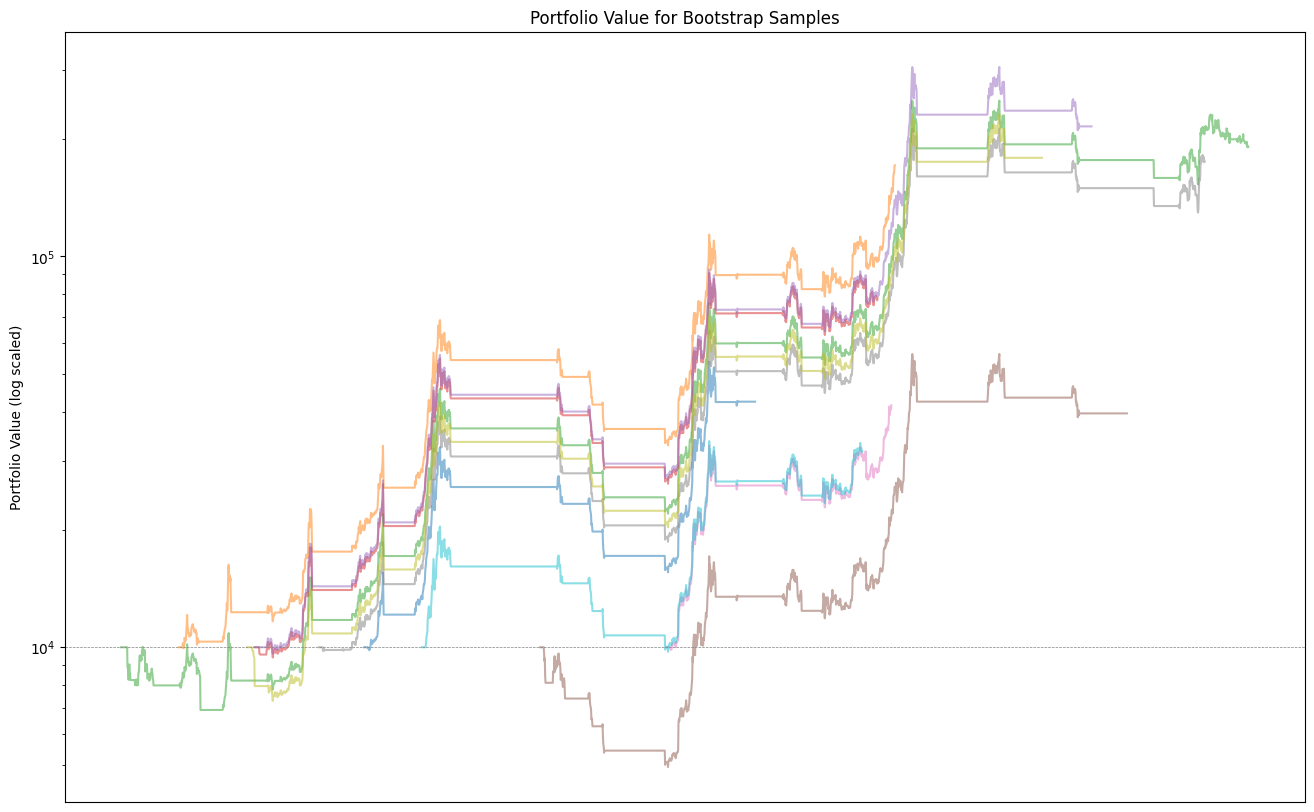

In [ ]:
def bootstrap_resampling(df, block_size=200, iterations=100):
    bootstrap_results = []
    n_blocks = int(np.ceil(len(df) / block_size))  # Number of blocks needed to approximate the original data length

    # Prepare a DataFrame to store aggregated results, excluding the 'Portfolio' DataFrame
    aggregated_results = pd.DataFrame()

    for i in range(iterations):
        # Randomly choose starting indices for block sampling
        np.random.seed(i)
        block_start_indices = np.random.choice(len(df) - block_size + 1, n_blocks, replace=True)

        # Extract blocks and concatenate them
        blocks = [df.iloc[idx:idx + block_size] for idx in block_start_indices]
        resampled_data = pd.concat(blocks).reset_index(drop=True)

        # Ensure the resampled data is not longer than the original data
        resampled_data = resampled_data.iloc[:len(df)]

        # Fetch resampled prices using residuals
        # price_copy = df.copy(deep=True)
        # bootstrap_residual_prices = generate_resampled_btc_prices(price_copy, i)

        # Fetch prices with random start and end
        price_copy2 = df.copy(deep=True)
        random_startend_prices = generate_btc_prices_with_random_start_n_end(price_copy2, i)

        # Apply the trading strategy to the resampled data
        resampled_data.index = df.index
        # result = trading_strategy(bootstrap_residual_prices)
        result = trading_strategy(random_startend_prices)
        bootstrap_results.append(result)

        # Add the results to the list, excluding 'Portfolio'
        result_without_portfolio = {key: value for key, value in result.items() if key != 'Portfolio'}
        aggregated_results = pd.concat([aggregated_results, pd.DataFrame([result_without_portfolio])], ignore_index=True)

    # Convert the list of dictionaries to a DataFrame
    aggregated_results_df = pd.DataFrame(aggregated_results)

    # Save the aggregated results to an Excel file
    csv_path = '/content/bootstrap_results.csv'
    aggregated_results_df.to_csv(csv_path, index=False)

    return bootstrap_results


btc = btc_real_price.copy()
bootstrap_results = bootstrap_resampling(btc, block_size=200, iterations=10)

# print(bootstrap_results)

plt.figure(figsize=(16, 10))  # Set the figure size for better readability

# Plot each bootstrap sample's portfolio value
for i, result in enumerate(bootstrap_results):
    portfolio_value = result['Portfolio']['total']
    plt.plot(portfolio_value, alpha=0.5)  # Alpha for transparency

# Set the y-axis to be log-scaled
plt.yscale('log')

# Set the y-axis limits
# plt.ylim(10000 / 4, 50000 * 2)

# Center y-axis at 10000 with a horizontal line
plt.axhline(y=10000, color='gray', linestyle='--', lw=0.5)

plt.title('Portfolio Value for Bootstrap Samples')
plt.ylabel('Portfolio Value (log scaled)')

# Remove the x-axis
plt.gca().axes.xaxis.set_visible(False)

plt.show()

Number of round-trip trades: 22
Total Return: 2178.30%
Annualized Return: 39.57%
Buy & Hold Return: 9291.96%
Winning Trades: 45.45%
Strategy Sharpe Ratio: 0.90
Buy & Hold Sharpe Ratio: 0.87
Maximum Drawdown: -52.18%


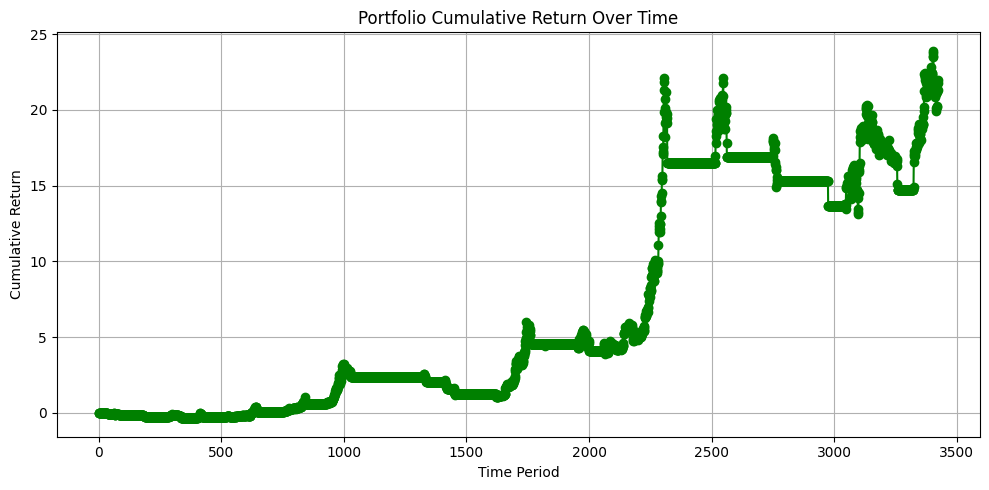

In [ ]:
btc_prices = btc_real_price.copy()

real_result_dict = trading_strategy(btc_prices, False, 0.00)

# Print the metrics
print(f"Number of round-trip trades: {real_result_dict['Number of round-trip trades']}")
print(f"Total Return: {real_result_dict['Total Return']}%")
print(f"Annualized Return: {real_result_dict['Annualized Return']}%")
print(f"Buy & Hold Return: {real_result_dict['Buy & Hold Return']}%")
print(f"Winning Trades: {real_result_dict['Winning Trades']}%")
print(f"Strategy Sharpe Ratio: {real_result_dict['Strategy Sharpe Ratio']}")
print(f"Buy & Hold Sharpe Ratio: {real_result_dict['Buy & Hold Sharpe Ratio']}")
print(f"Maximum Drawdown: {real_result_dict['Maximum Drawdown']}%")

# print(real_result_dict["Portfolio"])
plot_cumulative_return(real_result_dict["Portfolio"])